# Transient Advection-Diffusion
This example will show how to preform a transient advection-diffusion simulation on a 2D Cubic network.

In [1]:
import openpnm as op
%config InlineBackend.figure_formats = ['svg']
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(precision=3)

# Generating Network
A 2D 40 X 40 ``Cubic`` network is generated with a spacing of $10^{-4}$m, but a 3D network would work as well. The geometry, phase, and physics are also defined as follows.

In [2]:
pn = op.network.Cubic(shape=[40, 40], spacing=1e-4)
geo = op.geometry.StickAndBall(network=pn, pores=pn.Ps, throats=pn.Ts)
water = op.phases.Water(network=pn)
phys = op.physics.Standard(network=pn, phase=water, geometry=geo)

# Defining Effective Pore Volume

The accumulation of mass in the network occurs only in the pores, where the concentration is solved.  In order for mass  accumulate properly, it is necessary to assign the throat volumes to their surrounded throats.  This creates an effective pore volume.  We can define this in a custom pore-scale model, making use of the ``numpy.add.at`` function, to add 1/2 the volume of each throat to its neighboring pores.  

In [3]:
def effective_pore_volume(target, throat_volume='throat.volume', pore_volume='pore.volume'):
    Pvol = geo['pore.volume']
    Tvol = geo['throat.volume']
    Vtot = Pvol.sum() + Tvol.sum()
    np.add.at(Pvol, pn.conns[:, 0], geo['throat.volume']/2)
    np.add.at(Pvol, pn.conns[:, 1], geo['throat.volume']/2)
    assert np.isclose(Pvol.sum(), Vtot)  # Ensure total volume has been added to Pvol
    return Pvol

In [4]:
geo.add_model(propname='pore.effective_volume', model=effective_pore_volume)

# Perform Stokes flow
The advection diffusion algorithm assumes a velocity field. Therefore, Stokes flow in the pore netwok is solved. The ``StokesFlow`` algorthm is solved prior to running the ``AdvectionDiffusion`` algorthim. For more information there is a seperate tutorial on Stokes Flow.

In [5]:
sf = op.algorithms.StokesFlow(network=pn, phase=water,)
sf.set_value_BC(pores=pn.pores('back'), values=50.0)
sf.set_value_BC(pores=pn.pores('front'), values=0)
sf.run();

The results obtained from the StokesFlow algorthim must be attached to the water phase.

In [6]:
water.update(sf.results())

# Add Diffusive Conductance Model

In [7]:
mod = op.models.physics.ad_dif_conductance.ad_dif
phys.add_model(propname='throat.ad_dif_conductance', model=mod, s_scheme='powerlaw')

# Define Transient Advection Diffusion
An algorthim for transient advection diffusion is defined here. It is assigned to the network and the phase, and will be able to retrieve all information that will be needed.

In [8]:
ad = op.algorithms.TransientAdvectionDiffusion(network=pn, phase=water) 

The Dirichlet boundary conditions and the inital conditions are next defined as follows. If the inital condition is not defined then it is assumed to be zero, so it is redundunt in this case. The boundary conditions can be defined as ``value``, ``outflow``, and ``rate``.

In [9]:
inlet  = pn.pores('back') 
outlet = pn.pores('front')
ad.set_value_BC(pores=inlet, values=1.0)
ad.set_outflow_BC(pores=outlet)
ad.set_IC(0)

# Setup the Transient Algorithim
The settings of the transient algorthim can be updated here. The time discretazition scheme, t_scheme, is set to cranknicolson which is second-order accurate in time. The other two settings for t_scheme are implicit (which is first order, and therefore faster but less accurate) and steady, which will be a steady-state simulation.

The other parameters defined are the final time step, t_final, the outputing time stepping t_output, the time step ``t_step``, and the tolerance to be achieved before reaching steady state t_tolerance.


In [10]:
tf = 100
tstep = 10
ad.setup(t_scheme='implicit', t_final=tf, t_output=5, t_step=tstep, t_tolerance=1e-12)

We must also tell the algorithm to use the effective pore volume rather than the default which is just 'pore.volume'

In [11]:
ad.settings['pore_volume'] = 'pore.effective_volume'

The algorthim than can be run.

In [12]:
ad.run()

We can print the algorthims settings as follows:

In [13]:
print(ad.settings)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
key                                 value
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
name                                alg_02
cache_A                             True
cache_b                             True
conductance                         throat.ad_dif_conductance
phase                               phase_01
quantity                            pore.concentration
solver_atol                         None
solver_family                       pypardiso
solver_max_iter                     5000
solver_preconditioner               jacobi
solver_rtol                         None
solver_tol                          1e-08
solver_type                         spsolve
prefix                              alg
nlin_max_iter                       5000
relaxation_quantity                 1.0
relaxation_source                   1.0
sources                             []
diffusive_condu

The solution at eveery time step is stored in the algorthim, and can be printed as follows.

In [14]:
print(ad)

――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
openpnm.algorithms.TransientAdvectionDiffusion : alg_02
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
#     Properties                                    Valid Values
――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――――
1     pore.bc_outflow                                  40 / 1600 
2     pore.bc_rate                                      0 / 1600 
3     pore.bc_value                                    40 / 1600 
4     pore.concentration                             1600 / 1600 
5     pore.concentration@0                           1600 / 1600 
6     pore.concentration@10                          1600 / 1600 
7     pore.concentration@100                         1600 / 1600 
8     pore.concentration@20                          1600 / 1600 
9     pore.concentration@30                          1600 / 1600 
10    pore.concentration@40                     

# Visualization using Matplotlib
The pore concentration can be visualized using a 2D heatmap using matplotlib.

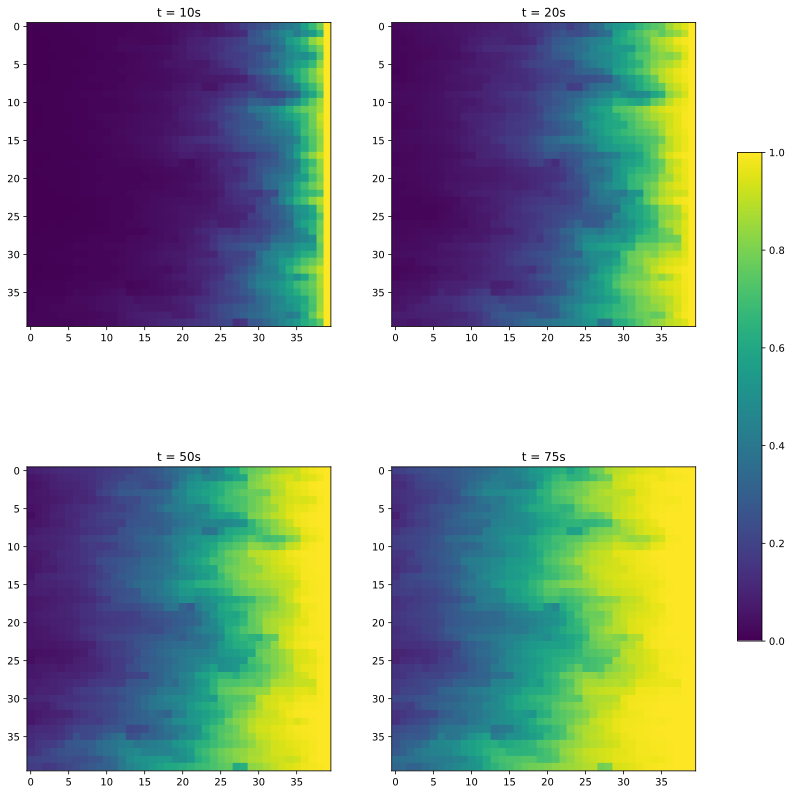

In [15]:
cq = ad['pore.concentration@'+str(10)]
cw = ad['pore.concentration@'+str(20)]
ce = ad['pore.concentration@'+str(30)]
cr = ad['pore.concentration@'+str(40)]
cq2d = cq.reshape((pn._shape))
cw2d = cw.reshape((pn._shape))
ce2d = ce.reshape((pn._shape))
cr2d = cr.reshape((pn._shape))
fig,a = plt.subplots(2,2,figsize=(15, 15));
im = a[0][0].imshow(cq2d[:,:,0],vmin=0,vmax=1);
a[0][0].set_title('t = '+str(10)+'s')
a[0][1].imshow(cw2d[:,:,0],vmin=0,vmax=1);
a[0][1].set_title('t = '+str(20)+'s')
a[1][0].imshow(ce2d[:,:,0],vmin=0,vmax=1);
a[1][0].set_title('t = '+str(50)+'s')
a[1][1].imshow(cr2d[:,:,0],vmin=0,vmax=1);
a[1][1].set_title('t = '+str(75)+'s')
plt.colorbar(im, ax=a, shrink = 0.6)
plt.show()

# Peclet Number

The Peclet number is a dimensionless number defined as the ratio of the rate of advective transport to the rate of diffusive transport. This is often a useful number to know when analyzing advection diffusion problems. It can be calculated using the following equation:

$$Pe_{throat} = \frac{q_{throat}L}{AD_{Ae}}$$

Where $q_{throat}$ is the volumetric flow rate for the throat, $L$ is the length of the throat, $A$ is the cross sectional area of the throat, and $D_{Ae}$ is the diffusion coefficent. A histogram representing the peclet numbers of all throats is presented below as well.

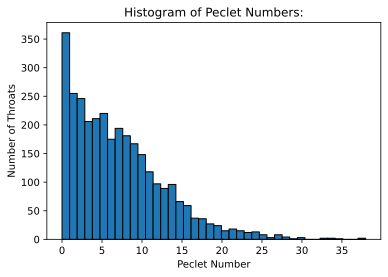

Average Peclet Number = 7.143648603416037


In [16]:
q_throat = sf.rate(throats=pn.Ts,mode='single')
L = pn['throat.length']
A = (np.pi/4)*(pn['throat.diameter']**2)
Pe_1 = q_throat*L/(A*water['throat.diffusivity'])
n, bins, patches = plt.hist(Pe_1, bins=40, edgecolor='k')
plt.xlabel('Peclet Number')
plt.ylabel('Number of Throats')
plt.title(r'Histogram of Peclet Numbers:')
plt.show()
def Average(l): 
    avg = sum(l) / len(l) 
    return avg
Pe_ave = Average(Pe_1)
print("Average Peclet Number = " + str(Pe_ave))

# Elution Curve



Text(0, 0.5, 'Concentration')

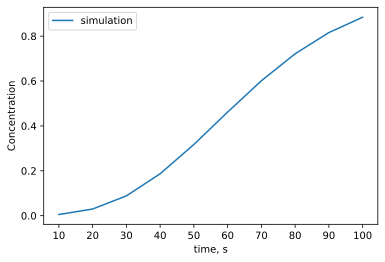

In [17]:
Pores_front = pn.pores(['front'])
Throats_front = pn.find_neighbor_throats(pores=Pores_front, mode='xor')
steps = tf/tstep +1
count = 0
C_ave = []
td = ad.settings['t_solns']
for step in td:
    conc_front = ad['pore.concentration@'+str(step)][Pores_front]
    q_front = sf.rate(throats=pn.Ts,mode='single')[Throats_front]
    C_ave.append(np.sum(q_front*conc_front)/np.sum(q_front))
plt.plot(td, C_ave)
plt.gca().legend(('simulation','fitted'))
plt.xlabel('time, s')
plt.ylabel('Concentration')

# Solving for the Dispersion Coefficient

The following equation given by Fried (1971) is used to solve the longitudinal dispersion coefficient:

$$\frac{C}{C_{0}} = \frac{1}{2}erfc\Bigl(\frac{x-Ut}{2(D_{L}t)^{\frac{1}{2}}}\Bigr)+\frac{1}{2}exp\Bigl(\frac{Ux}{D_{L}}\Bigl)erfc\Bigr(\frac{x+Ut}{2(D_{L}t)^{\frac{1}{2}}}\Bigr)$$

Where $x$ is the length between the inlet and the outlet, $t$ is the time, $D_{L}$ is the longitudinal dispersion coefficient, $U$ is the average pore velocity, $C_{0}$ is the inlet concentration, and $C$ is the concentration at the given time. Since we defined the inlet concentration as being equal to 1, solving for $C$ is effictivly equal to solving for $\frac{C}{C_{0}}$. ``erfc`` is the complementary error function, which is imported from ``scipy``.



In [18]:
from scipy import special
q_throat = sf.rate(throats=pn.Ts, mode='single')
A_throat = pn['throat.area']
v_throat = q_throat/A_throat
v_pred = sum(q_throat*v_throat)/sum(q_throat)
def elution(step,v,DL):
    x = 40*1e-4
    el1 = 0.5*(special.erfc((x-step*v)/(2*(DL*step)**(1/2))))
    el2 = 0.5*np.exp(v*x/DL)
    el3 = special.erfc((x+step*v)/(2*(DL*step)**(1/2)))
    return el1+el2*el3

In [19]:
g = [v_pred, 1e-3]
xdata = [float(x) for x in td]
ydata = C_ave
from scipy.optimize import curve_fit
popt, pcov = curve_fit(elution, xdata, ydata, p0=g)
disp_coeff = popt[1]
v_fit = popt[0]
print('Dispersion Coefficient = ', "{0:.4E}".format(disp_coeff), ' m^2/s')
print('v_pred = ', "{0:.4E}".format(v_pred), ' m/s')
print('v_fitted = ', "{0:.4E}".format(v_fit), ' m/s')

Dispersion Coefficient =  2.5985E-08  m^2/s
v_pred =  2.2569E-04  m/s
v_fitted =  5.8982E-05  m/s


Text(0, 0.5, 'Concentration')

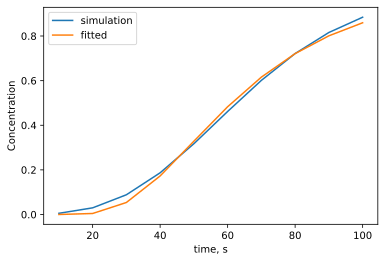

In [20]:
el = [0 for i in range(len(ydata))]
for i in range(len(ydata)):
    el[i] = elution(xdata[i], popt[0], popt[1])
plt.plot(xdata, ydata, xdata, el)
plt.gca().legend(('simulation','fitted'))
plt.xlabel('time, s')
plt.ylabel('Concentration') 